# Continuous Control

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [ ]:
import os
file_path = os.path.abspath("Reacher_Linux/Reacher.x86_64")
env = UnityEnvironment(file_name=file_path, no_graphics=True)

Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [ ]:
# select this option to load version 1 (with a single agent) of the environment
env_file_name = os.path.abspath("Reacher_Linux/Reacher.x86_64")
env = UnityEnvironment(file_name=env_file_name, no_graphics=True)

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
print(brain_name)

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

### 3. Training

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [ ]:
from collections import namedtuple, deque
import matplotlib.pyplot as plt
import pandas as pd

#### Import Agent

Different from default the sampling approach, a simple Gaussian sampling is used with sigam decay.

In [ ]:
from agent import *

#### Training Script

In [10]:
def train(agent, n_episodes=1800, max_t=1000):
    """Deterministic Critic and Actor training.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores

    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        state = env_info.vector_observations[0]           # get the current state
        score = 0
        for t in range(max_t):
            action = agent.act(state, i_episode, add_noise=True)
            env_info   = env.step(action)[brain_name]      # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            reward     = env_info.rewards[0]               # get the reward
            done       = env_info.local_done[0]            # see if episode has finished
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score

        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if i_episode % 100 == 0 and np.mean(scores_window)>=30.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.actor_local.state_dict(), 'actor_checkpoint.pth')

    return scores

In [8]:
def plot_scores(scores, filename, rolling_window=100):
    """Plot scores and optional rolling mean using specified window."""
    plt.figure(figsize=(19.20,10.80))
    plt.plot(scores, color='b', linestyle='-', linewidth=0.75) 
    plt.title("Scores");
    rolling_mean = pd.Series(scores).rolling(rolling_window, min_periods=1).mean()
    plt.plot(rolling_mean, color='r', linestyle='-', linewidth=0.75)
    plt.ylim(0, 50)
    if filename is not None:
        plt.savefig(filename)

#### Train DDPG: higher sigma for exploration

Episode 100	Average Score: 1.82
Episode 200	Average Score: 15.39
Episode 300	Average Score: 32.62

Environment solved in 200 episodes!	Average Score: 32.62
Episode 400	Average Score: 35.56

Environment solved in 300 episodes!	Average Score: 35.56
Episode 500	Average Score: 33.95

Environment solved in 400 episodes!	Average Score: 33.95


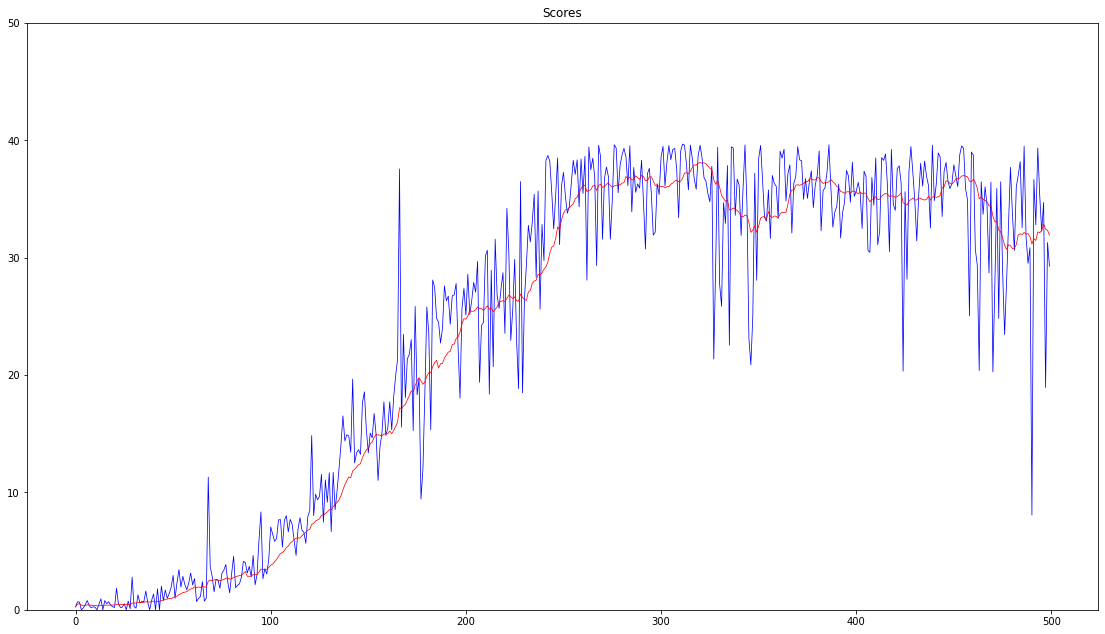

In [6]:
class Params:
    """Set up configuration here."""
    def __init__(self):
        self.__dict__.update(**{
            'buffer_size' : int(1e5),  # replay buffer size
            'batch_size'  : 128,       # minibatch size
            'gamma'       : 0.99,      # discount factor
            'tau'         : 1e-3,      # for soft update of target parameters
            'lr'          : 6e-4,      # learning rate 
            'update_every' : 4,        # how often to update the network
            'max_sigma'    : 0.8,      # max. sigma for continuous exploration
            'min_sigma'    : 0.001,    # min. sigma for continuous exploration
            'end_episode'  : 500,      # last episode for sigma decay
})
        
device = torch.device("cpu")

params = Params()

agent = DeterministicACagent(state_size=state_size, action_size=action_size, params=params, device=device)
scores = train(agent, n_episodes=500)

filename = 'DDPG.jpg'
plot_scores(scores=scores, filename=filename, rolling_window=20)

#### Train DDPG: lower sigma for exploration

Episode 100	Average Score: 1.84
Episode 200	Average Score: 13.82
Episode 300	Average Score: 31.08

Environment solved in 200 episodes!	Average Score: 31.08
Episode 400	Average Score: 33.49

Environment solved in 300 episodes!	Average Score: 33.49
Episode 500	Average Score: 35.80

Environment solved in 400 episodes!	Average Score: 35.80


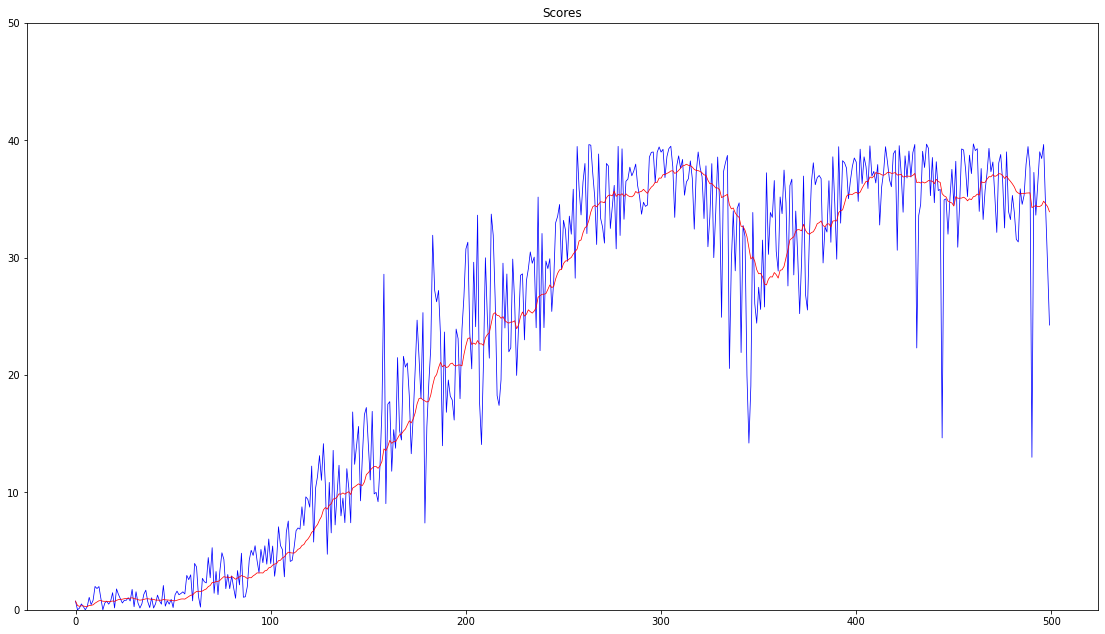

In [11]:
class Params:
    """Set up configuration here."""
    def __init__(self):
        self.__dict__.update(**{
            'buffer_size' : int(1e5),  # replay buffer size
            'batch_size'  : 128,       # minibatch size
            'gamma'       : 0.99,      # discount factor
            'tau'         : 1e-3,      # for soft update of target parameters
            'lr'          : 6e-4,      # learning rate 
            'update_every' : 4,        # how often to update the network
            'max_sigma'    : 0.5,      # max. sigma for continuous exploration
            'min_sigma'    : 0.001,    # min. sigma for continuous exploration
            'end_episode'  : 500,      # last episode for sigma decay
})
        
device = torch.device("cpu")

params = Params()

agent = DeterministicACagent(state_size=state_size, action_size=action_size, params=params, device=device)
scores = train(agent, n_episodes=500)

filename = 'DDPG_sigma_0_5.jpg'
plot_scores(scores=scores, filename=filename, rolling_window=20)

#### Train DDPG: lowest sigma for exploration

Episode 100	Average Score: 1.44
Episode 200	Average Score: 8.25
Episode 300	Average Score: 14.08
Episode 400	Average Score: 17.64
Episode 500	Average Score: 19.91


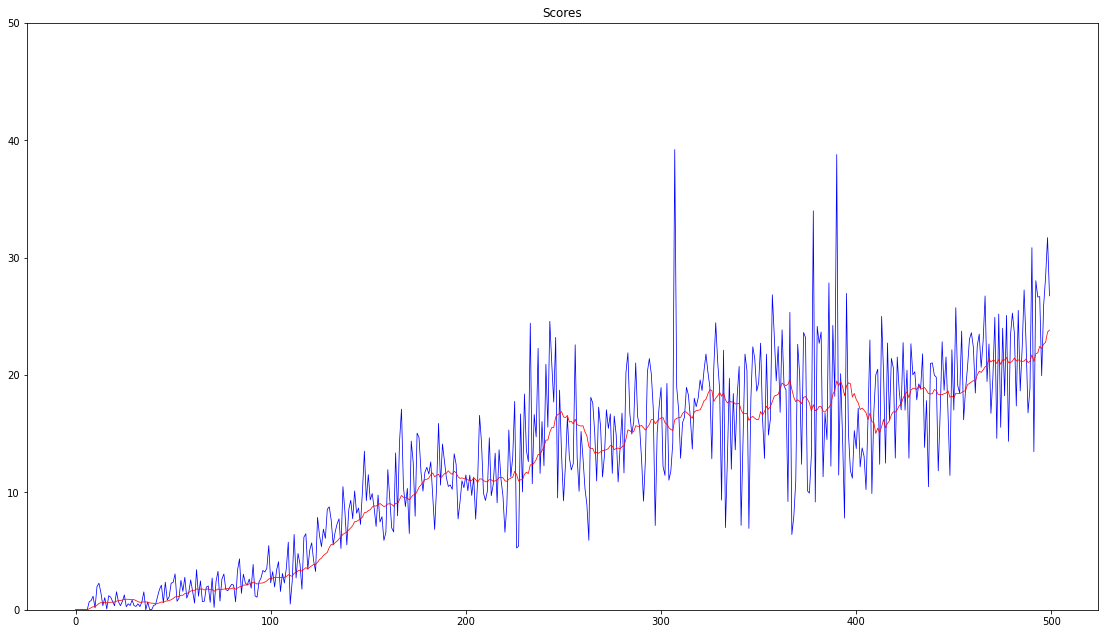

In [12]:
class Params:
    """Set up configuration here."""
    def __init__(self):
        self.__dict__.update(**{
            'buffer_size' : int(1e5),  # replay buffer size
            'batch_size'  : 128,       # minibatch size
            'gamma'       : 0.99,      # discount factor
            'tau'         : 1e-3,      # for soft update of target parameters
            'lr'          : 6e-4,      # learning rate 
            'update_every' : 4,        # how often to update the network
            'max_sigma'    : 0.2,      # max. sigma for continuous exploration
            'min_sigma'    : 0.001,    # min. sigma for continuous exploration
            'end_episode'  : 500,      # last episode for sigma decay
})
        
device = torch.device("cpu")

params = Params()

agent = DeterministicACagent(state_size=state_size, action_size=action_size, params=params, device=device)
scores = train(agent, n_episodes=500)

filename = 'DDPG_sigma_0_2.jpg'
plot_scores(scores=scores, filename=filename, rolling_window=20)

### 4. Conclusion

As the investigation shown above, higher expolration is beneficial to this task. Different from the default sampling scheme OUNoise, Gaussian sampling based on continuos action output with decay gives fair result as well. It may be because Gaussian sampling with small sigma gives small deviations to action space which explores rewards efficiently in this task. However, it doesn't other tasks can enjoy the same benifit. 

### 5. Future Work

The A2C prototype is implemented in this repo but after a few trials still no success. The future work is to investigate the reason and make some modifications.